In [1]:
import pandas as pd
import numpy as np
import sqlite3
import gspread
import scrapbook as sb
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter
from pandas.plotting import scatter_matrix

C:\Users\lenovo\AppData\Local\conda\conda\envs\lecture_4\lib\site-packages\papermill\iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [2]:
token = 'BTC'
from_date = '2021-12-03'
to_date = '2021-12-15'
connection_string = 'sqlite:///data/data.db'

In [3]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection_string)
prices['ts'] = pd.to_datetime(prices['ts'])

prices.set_index('ts', inplace=True)

In [4]:
def series_plot(data, events=None, ax=None):
    data.plot(ax=ax)
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)

    if events is not None:
        ymin, ymax = ax.get_ylim()
        text_pos = 1
        
        for idx, row in events.loc[data.index[0]:data.index[-1]].iterrows():
            if row.impact == 1:
                text_pos = (text_pos + 1) % 2
                x = idx
                ax.axvline(x, color='0.2', linestyle=':')
                ax.text(x, ymin, row.event, rotation=90, color='0.2')    
            elif row.impact == 2:
                text_pos = (text_pos + 1) % 2
                x = idx
                ax.axvline(x, color='0.6', linestyle=':')
                ax.text(x, ymin, row.event, rotation=90, color='0.6')

In [5]:
def index_cal(df,lookback=10):
    c = df.close
    cc = np.log(c/c.shift(1))
    cc_sq = cc**2
    hour_return = c.pct_change()
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    max_c = c.cummax()
    max_drawdown = (max_c - c)/max_c
    new_df = pd.DataFrame({'hour_return':hour_return,'close_vol':close_vol,'max_drawdown':max_drawdown,'close':c})
    
    return new_df
    
    
    

In [6]:
factors = index_cal(prices)

In [7]:
%%capture

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

In [8]:
series_plot(factors[['close']], ax=ax[0, 0])
series_plot(factors[['hour_return']], ax=ax[1, 0])
series_plot(factors[['close_vol']],ax = ax[0,1])
series_plot(factors[['max_drawdown']], ax=ax[1, 1])
fig.suptitle(f'Market action for {token} between {from_date} and {to_date}')

Text(0.5, 0.98, 'Market action for BTC between 2021-12-03 and 2021-12-15')

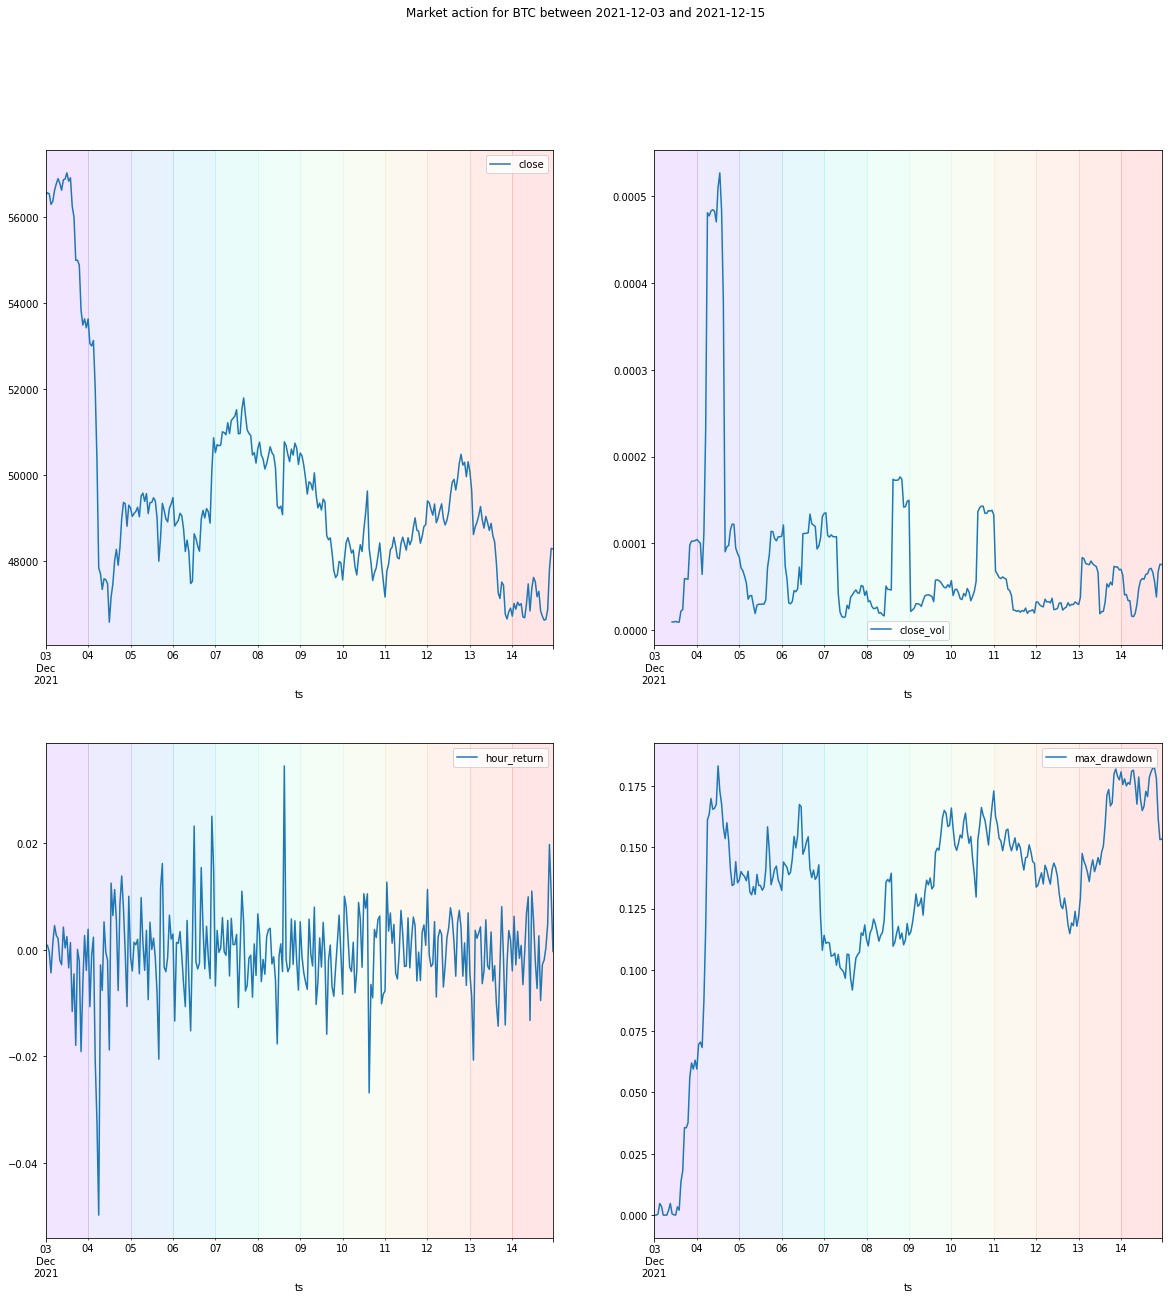

In [9]:
fig

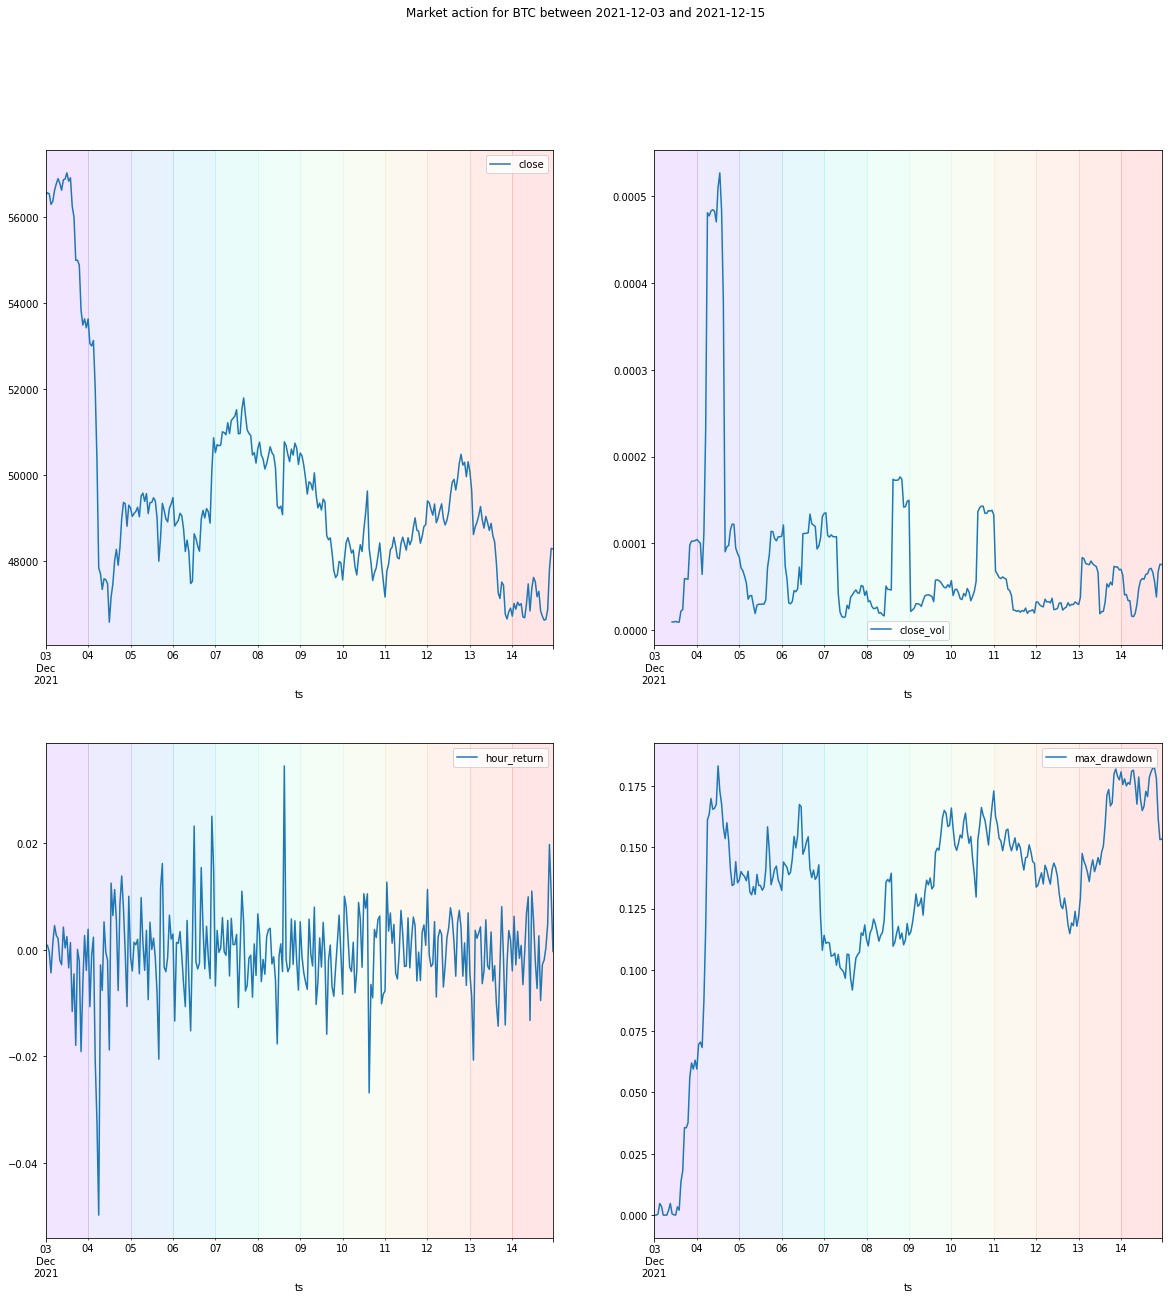

In [10]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('factors', factors, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)